In [1]:
#Basic imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
import warnings

# Data Processing

In [2]:
# Import data
#data = pd.read_excel('data.xlsx', 'Timepoint 1', header=1)
data = pd.read_excel('data2.xlsx', 'Sheet1', header=0)

In [3]:
data['Date of birth'] = pd.to_datetime(data['Date of birth'].astype(str), format='%d/%m/%Y')
data['Date of MRI scan'] = pd.to_datetime(data['Date of MRI scan'].astype(str), format='%Y-%m-%d', errors='ignore')
data['Age'] = (data['Date of MRI scan'] - data['Date of birth'])/ np.timedelta64(1, 'Y')

In [4]:
def clean_data(df, del_col=[], mean=[], std=[]):
    X = df.copy()
    
    # Remove useless columns
    X = X.drop(['Subject ID', 'Date of birth', 'Date of MRI scan'], axis=1)
    #X = X.drop(['Patient ID', 'Batch Process ID'], axis=1)
    
    # Remove columns with only zeros
    if (len(del_col) == 0):
        del_col = (X != 0).any(axis=0)
    X = X.loc[:, del_col]
    
    # Replace zeros by nan
    X.replace(0, np.nan, inplace=True)
    
    # Replace Sex labels by values
    #X['Sex'].replace({'Male':1,'Female':2}, inplace=True)
    
    # Categorical values
    cater = X[['Gender']]
    #cater = X[['Sex']]
    
    # Numerical values
    numer = X.drop(['Gender'], axis=1)
    #numer = X.drop(['Sex'], axis=1)
    
    # Replace nan values by mean of column
    if (len(mean) == 0 or len(std) == 0):
        mean = numer.mean()
        std = numer.std()
        std = std.fillna( 1)
    numer = numer.fillna(mean)
                 
    
    #Scale each column in numer
    numer = (numer - mean)/std
    
    new_X = pd.concat([numer, cater], axis=1, join='inner')
    
    return new_X, del_col, mean, std

In [35]:
data_train, data_test, y_train, y_test = train_test_split(data.drop(['Age'], axis=1), data['Age'], test_size=0.3, random_state=2)

In [36]:
x_train, del_col, mean_train, std_train = clean_data(data_train)
x_test, _, _, _ = clean_data(data_test, del_col, mean_train, std_train)

In [37]:
x_train

,Left Precentral gyrus,Right Precentral gyrus,Left Superior frontal gyrus-dorsolateral,Right Superior frontal gyrus-dorsolateral,Left Middle frontal gyrus,Right Middle frontal gyrus,Left Inferior frontal gyrus-opercular part,Right Inferior frontal gyrus-opercular part,Left Inferior frontal gyrus-triangular part,Right Inferior frontal gyrus-triangular part,...,Lobule III of vermis,Lobule IV-V of vermis,Lobule VI of vermis,Lobule VII of vermis,Lobule VIII of vermis,Lobule IX of vermis,Lobule X of vermis,Raphe nucleus-dorsal,Raphe nucleus-median,Gender
155,1.568125,2.009655,1.918490,1.696051,1.804641,1.617916,1.191280,1.700628,1.850025,1.823327,...,2.230460,2.413496,2.090518,0.891893,2.202657,1.777340,1.265546,1.282211,1.121740,1
45,-0.078215,0.502284,-0.048505,-0.021721,-0.122949,0.188459,-0.035780,-0.095932,-0.389498,0.297949,...,0.815872,0.886419,0.194680,0.727182,0.971601,0.912540,-0.854612,0.195250,0.479613,2
179,-0.122995,0.122900,0.512992,-0.147169,0.408155,0.393321,-0.254790,0.645632,-0.255861,1.104303,...,0.717315,-0.795834,-0.769126,-0.870018,-0.573500,-0.743354,0.218037,-0.855478,-0.242779,2
159,0.284135,0.534222,0.364360,-0.011101,0.088718,-0.137005,-0.242790,-0.452519,-0.014555,-0.580453,...,1.012987,0.382096,-0.035680,0.003451,0.301638,0.720909,2.019753,0.159018,-0.804640,2
228,2.016836,2.033850,2.159884,2.158017,1.993722,1.817125,2.056822,1.736969,1.877259,1.134869,...,1.998561,2.549276,1.108177,2.424206,1.716934,1.335113,-0.159066,1.354675,2.245461,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,-1.433030,-1.319627,-0.880560,-1.075748,-1.228393,-0.944877,-0.526303,-1.287204,-0.734674,-0.629941,...,-0.807426,-1.464151,-1.129229,-1.603731,-0.766115,-0.433795,0.394019,-0.855478,-0.001982,2
22,-0.689138,-0.939276,-1.057301,-0.637677,-0.770856,-0.755629,-0.922323,-1.605180,-0.655505,-0.939965,...,-1.688645,-0.487245,0.279410,-0.251103,-0.146399,-0.212681,-0.963553,-1.254030,0.720411,2
72,1.445209,1.518005,1.210822,1.077772,1.204488,0.756473,0.937768,0.584308,1.603652,1.508936,...,0.062198,1.177375,0.716300,0.697234,2.525077,2.308012,-0.066885,1.535835,1.603335,1
15,1.247356,1.891582,1.561493,1.518167,1.589425,1.866658,1.569299,1.266819,1.489016,1.965967,...,1.285469,2.161335,2.469156,2.084801,1.603878,1.502176,2.296295,0.738730,1.041474,2


### K-Means
Find optimal number of clusters based on training set

_Results_ : 3

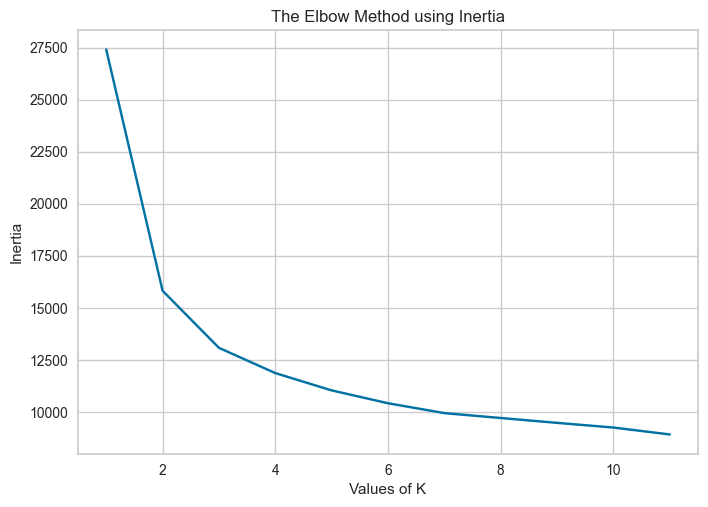

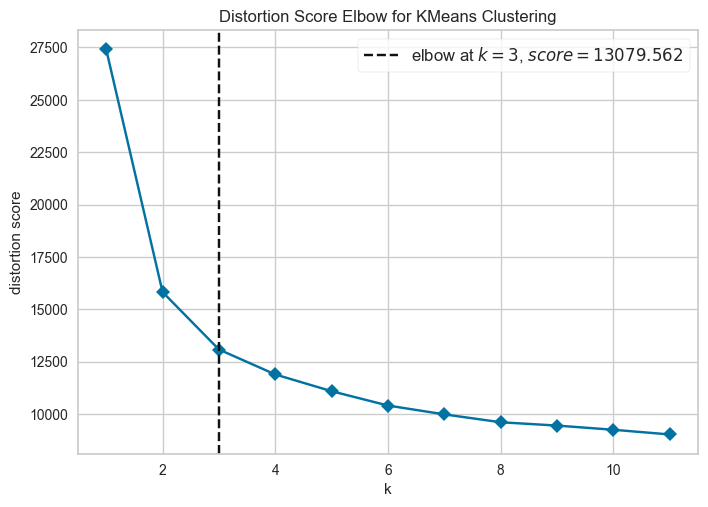

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
K = range(1, 12)
inertias = []
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(x_train)
    inertias.append(kmeanModel.inertia_)
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=K, timings=False)

visualizer.fit(x_train)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Train a KMean model on training data with 3 clusters. Then clusterize training and test set according to it.

In [43]:
# Train K-Means with 3 clusters
kmeanModel = KMeans(n_clusters=3).fit(x_train.drop(['Cluster', 'Gender'], axis=1, errors='ignore'))

# Assign train samples to clusters
x_train['Cluster'] = kmeanModel.labels_

# Assign test samples to clusters
x_test['Cluster'] = kmeanModel.predict(x_test.drop(['Cluster', 'Gender'], axis=1, errors='ignore'))

In [39]:
# GMM CLUSTERING
#from sklearn.mixture import GaussianMixture
#gmm = GaussianMixture(n_components=3).fit(x_train.drop(['Cluster'], axis=1, errors='ignore'))

# Assign train samples to clusters
#x_train['Cluster'] = gmm.predict(x_train.drop(['Cluster'], axis=1, errors='ignore'))

# Assign test samples to clusters
#x_test['Cluster'] = gmm.predict(x_test.drop(['Cluster'], axis=1, errors='ignore'))

### PCA

In [9]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures

In [134]:
def sub_PCA(x, y, i):
    pca = PCA(n_components=0.85)
    pc = pca.fit_transform(x.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
    pc = pd.DataFrame(data = pc, columns = ["PC%02d" %i for i in range(1,pca.n_components_+1)])
    
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title=f"% Cluster {i} - Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title=f"% Cluster {i} - Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=10, dpi=100)
    fig.show()
    
    mi_scores_PC = make_mi_scores(pc, y)
    mi_scores_feat = make_mi_scores(x, y)
    
    keep_features = mi_scores_feat[mi_scores_feat > 0].index.tolist()
    keep_PC = mi_scores_PC[mi_scores_PC > 0].index.tolist()
    
    return pca, pc, keep_features, keep_PC

In [132]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

### Submodel Training

In [152]:
from sklearn.ensemble import AdaBoostRegressor
def train_model(x, y):
    model = ElasticNet()
    #model = KernelRidge(kernel="rbf")
    #model = RandomForestRegressor(random_state=42)
    
    # Define model evaluation method
    cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    pipe = Pipeline([
            ('clf', AdaBoostRegressor(random_state = 123))
    ])
    
    # Define grid
    grid = {
        'clf__n_estimators': np.arange(1, 200, 20),
    }
    #'elastic__alpha': np.logspace(-10, 0, 15),
    #'elastic__l1_ratio': np.logspace(-10, 0, 15),
    #'krr__alpha': np.logspace(-10, 0, 15),
    #'krr__gamma': np.logspace(-10, 0, 15),
 
    #search = GridSearchCV(model, grid, cv=cv, n_jobs=1, scoring='neg_mean_absolute_error')
    search = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='r2', verbose=10)
    search.fit(x,y)
    
    return search.best_estimator_, search.best_score_

In [13]:
def predict(model, x_train, x_test):
    # Predict age
    predict_train = model.predict(x_train)
    predict_test = model.predict(x_test)
    
    return predict_train, predict_test

In [112]:
def plot_results(y_train, y_test, predict_train, predict_test, title):
    # Plot
    plt.figure(figsize=(10,10))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_xlabel('Train True Age', fontsize = 15)
    ax1.set_ylabel('Train Predicted Age', fontsize = 15)
    ax1.set_title(title, fontsize = 20)
    ax2.set_xlabel('Test True Age', fontsize = 15)
    ax2.set_ylabel('Test Predicted Age', fontsize = 15)
    ax2.set_title(title, fontsize = 20)
    ax1.axis('equal')
    ax2.axis('equal')
    ax1.grid()
    ax2.grid()

    ax1.scatter(y_train,
                predict_train,
                c = 'r', 
                s = 50)
    ax2.scatter(y_test,
                predict_test,
                c = 'r', 
                s = 50)

    p1 = max(max(predict_train), max(np.array(y_train)))
    p2 = min(min(predict_train), min(np.array(y_train)))
    ax1.plot([p1, p2], [p1, p2], 'b-')
    ax2.plot([p1, p2], [p1, p2], 'b-')

In [47]:
def compute_mae(y_train, y_test, predict_train, predict_test):
    # Compute error
    train_score = mean_absolute_error(y_train, predict_train)
    test_score = mean_absolute_error(y_test, predict_test)
    #train_score = r2_score(y_train, predict_train)
    #test_score = r2_score(y_test, predict_test)
    
    return train_score, test_score

In [48]:
def compute_r2(y_train, y_test, predict_train, predict_test):
    train_r2 = r2_score(y_train, predict_train)
    test_r2 = r2_score(y_test, predict_test)
    return train_r2, test_r2

### Run

Fitting 15 folds for each of 10 candidates, totalling 150 fits
-- Cluster 0 --
n_training_samples = 48
n_original_features = 172
n_kept_features = 94 | n_PC = 11
n_final_features = 91
best_score = 0.007771208142653537
train_score = 0.6365454808221376
test_score = 5.687057910614861
train_r2_score = 0.9686255875729011
test_r2_score = -1.2506139181189413
{'memory': None, 'steps': [('clf', AdaBoostRegressor(n_estimators=161, random_state=123))], 'verbose': False, 'clf': AdaBoostRegressor(n_estimators=161, random_state=123), 'clf__base_estimator': None, 'clf__learning_rate': 1.0, 'clf__loss': 'linear', 'clf__n_estimators': 161, 'clf__random_state': 123}
Fitting 15 folds for each of 10 candidates, totalling 150 fits
-- Cluster 1 --
n_training_samples = 46
n_original_features = 172
n_kept_features = 93 | n_PC = 11
n_final_features = 91
best_score = -0.006219388785441807
train_score = 0.6018535117864635
test_score = 3.5579296132900926
train_r2_score = 0.979098928218595
test_r2_score = 0.303835

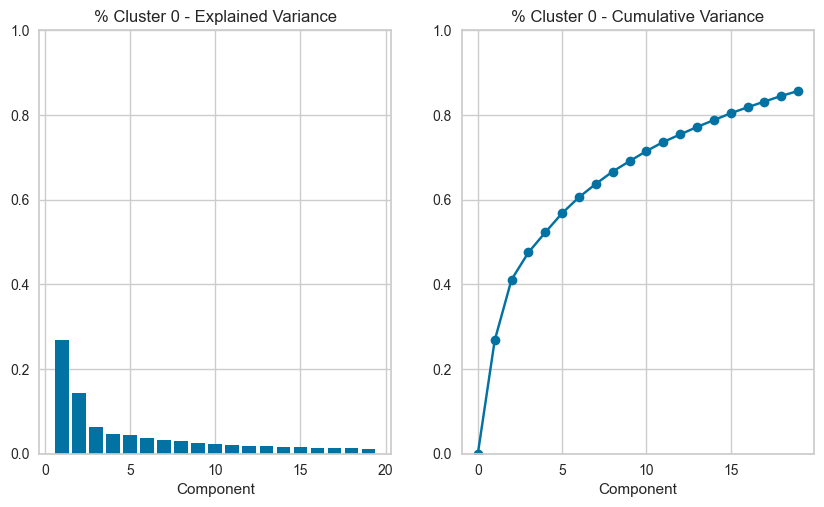

<Figure size 1000x1000 with 0 Axes>

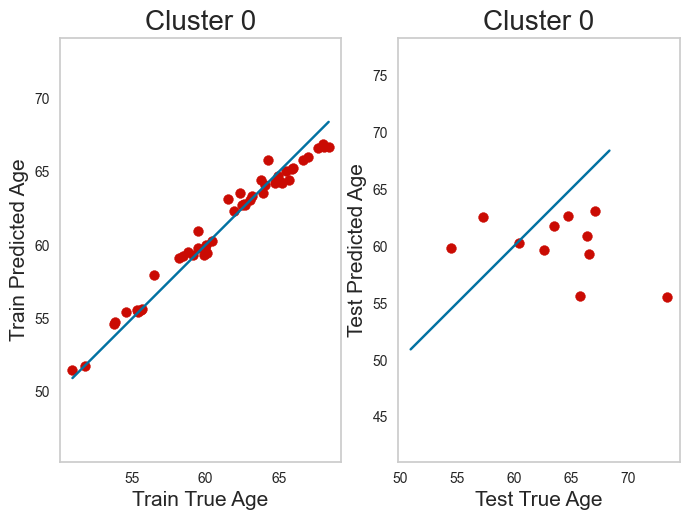

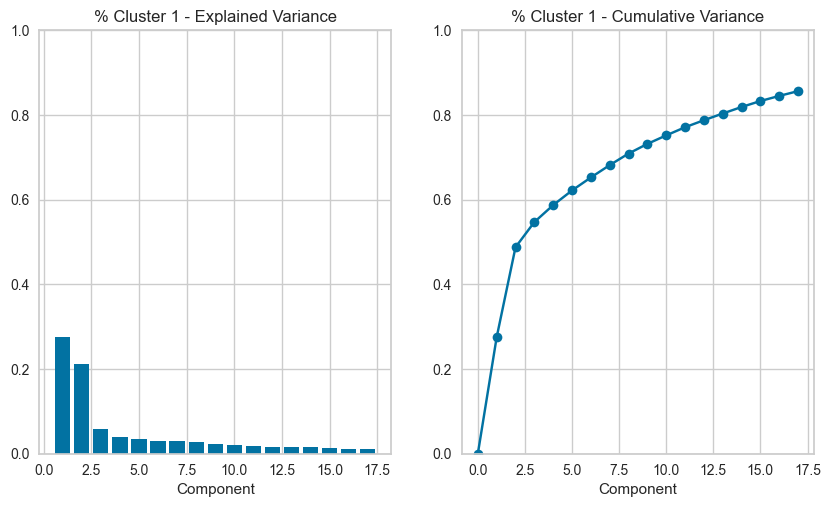

<Figure size 1000x1000 with 0 Axes>

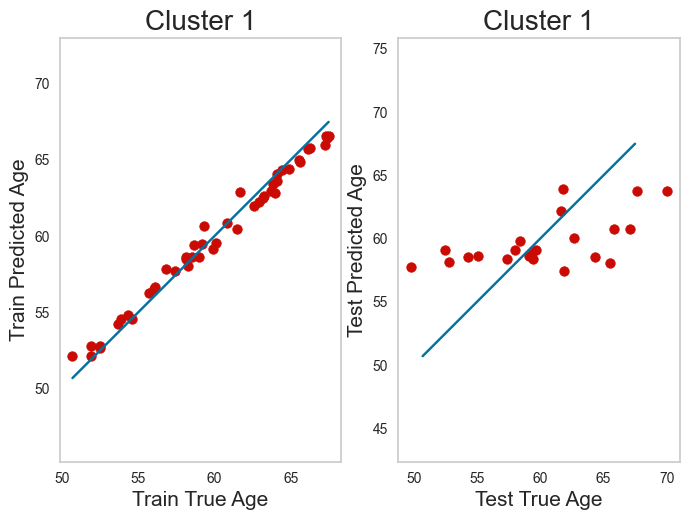

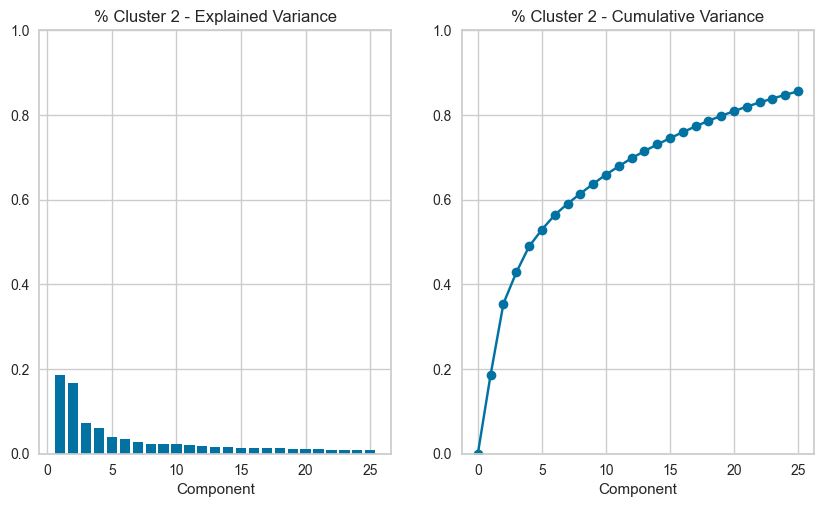

<Figure size 1000x1000 with 0 Axes>

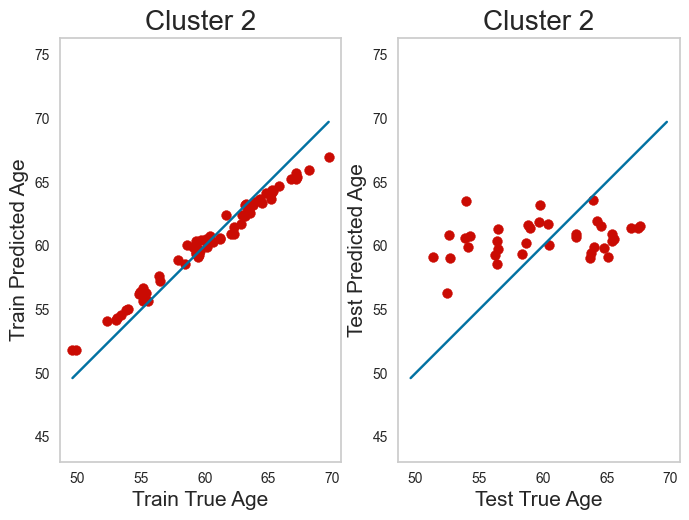

In [153]:
from sklearn import svm
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
predicts_test = {}
predicts_train = {}
ys_test = {}
ys_train = {}

for i in [0, 1, 2]:
    idx_train = x_train['Cluster'] == i
    idx_test = x_test['Cluster'] == i
    
    # Get subsets of Cluster i
    sub_x_train = x_train[idx_train].reset_index().drop(['index', 'Cluster'], axis=1, errors='ignore')
    sub_x_test = x_test[idx_test].reset_index().drop(['index', 'Cluster'], axis=1, errors='ignore')
    sub_y_train = y_train[idx_train].reset_index().drop(['index'], axis=1)
    sub_y_test = y_test[idx_test].reset_index().drop(['index'], axis=1)
    
    # PCA on train set
    pca, pc, keep_features, keep_PC = sub_PCA(sub_x_train, sub_y_train, i)
    
    new_sub_x_train = sub_x_train[keep_features]
    new_sub_x_test = sub_x_test[keep_features]
    
    # Train model
    best_model, best_score = train_model(sub_x_train, sub_y_train)
    
    # Compute predictions
    predict_train, predict_test = predict(best_model, sub_x_train, sub_x_test)
    
    # Compute MAE score
    train_score, test_score = compute_mae(sub_y_train, sub_y_test, predict_train, predict_test)
    
    #Compute R2 score
    train_r2, test_r2 = compute_r2(sub_y_train, sub_y_test, predict_train, predict_test)
    
    # Print results
    print(f'-- Cluster {i} --')
    print(f'n_training_samples = {sub_y_train.shape[0]}')
    print(f'n_original_features = {x_train.shape[1]}')
    print(f'n_kept_features = {len(keep_features)} | n_PC = {len(keep_PC)}')
    print(f'n_final_features = {poly_feat_train.shape[1] - 1}')
    print(f'best_score = {best_score}')
    print(f'train_score = {train_score}')
    print(f'test_score = {test_score}')
    print(f'train_r2_score = {train_r2}')
    print(f'test_r2_score = {test_r2}')
    print(best_model.get_params())
    #print(f'ElasticNet(alpha={best_model.get_params()["alpha"]}, l1_ratio={best_model.get_params()["l1_ratio"]})\n')
    #print(f'KernelRidge(kernel="sigmoid", alpha={best_model.get_params()["alpha"]}, gamma={best_model.get_params()["gamma"]})\n')
    #print(f'RandomForest(max_depth={best_model.get_params()["max_depth"]})\n')
    
    plot_results(sub_y_train, sub_y_test, predict_train, predict_test, f'Cluster {i}')
    
    predicts_train[i] = predict_train
    predicts_test[i] = predict_test

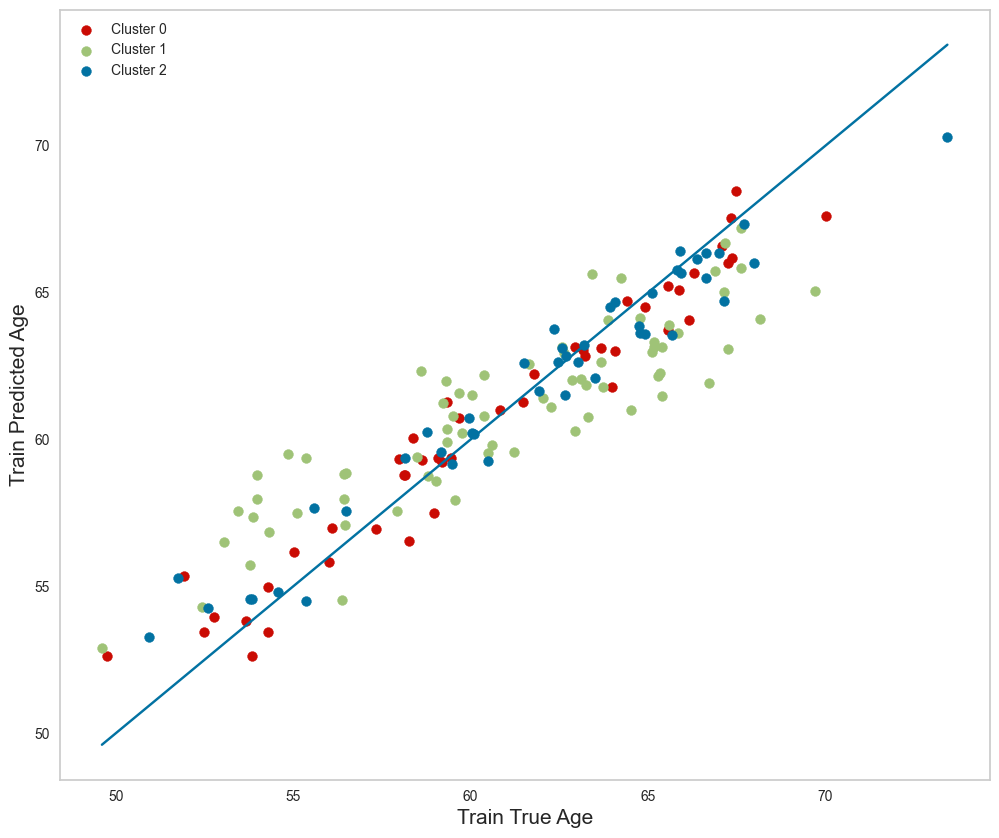

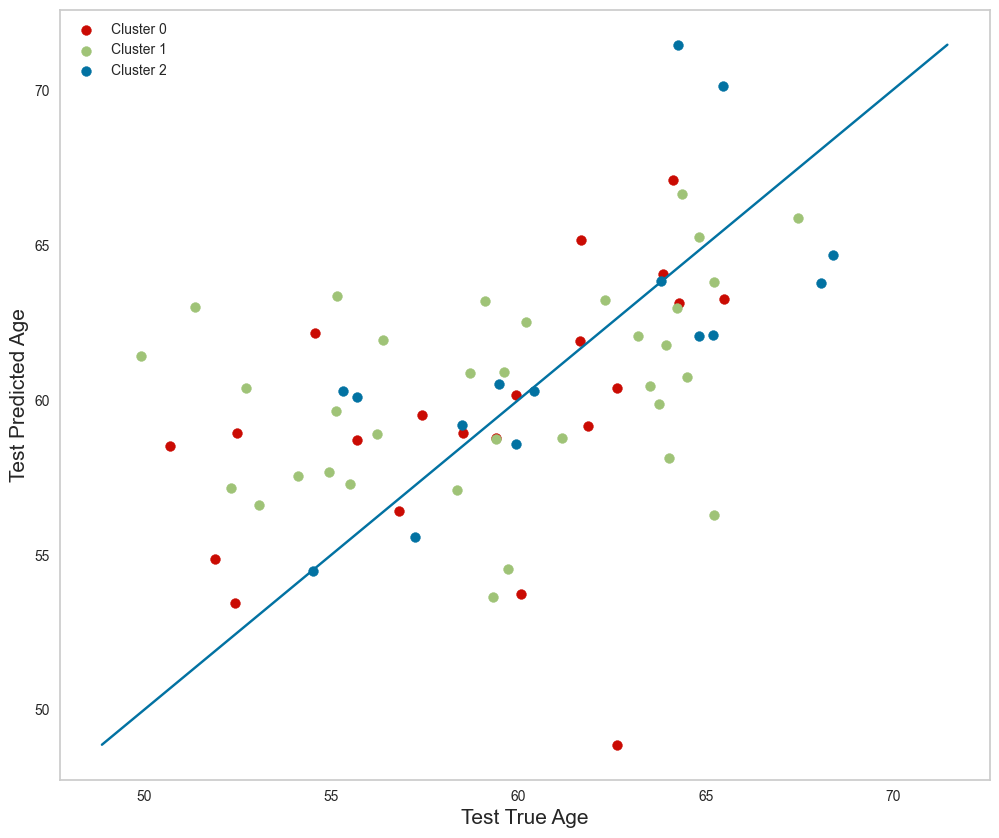

In [90]:
# Visualize all Clusters with a scatter plot
fig_global = plt.figure(figsize = (12,10))
ax_train = fig_global.add_subplot(1,1,1) 
ax_train.set_xlabel('Train True Age', fontsize = 15)
ax_train.set_ylabel('Train Predicted Age', fontsize = 15)

colors = ['r', 'g', 'b']
for i in [0, 1, 2]:
    idx = x_train['Cluster'] == i
    ax_train.scatter(y_train[idx], predicts_train[i], c = colors[i], s = 50)
p1 = max(max(np.concatenate([predicts_train[0], predicts_train[1], predicts_train[2]])), max(np.array(y_train)))
p2 = min(min(np.concatenate([predicts_train[0], predicts_train[1], predicts_train[2]])), min(np.array(y_train)))
plt.plot([p1, p2], [p1, p2], 'b-')
ax_train.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
ax_train.grid()

# Visualize Principal Components with a scatter plot
fig_global = plt.figure(figsize = (12,10))
ax_test = fig_global.add_subplot(1,1,1) 
ax_test.set_xlabel('Test True Age', fontsize = 15)
ax_test.set_ylabel('Test Predicted Age', fontsize = 15)

colors = ['r', 'g', 'b']
for i in [0, 1, 2]:
    idx = x_test['Cluster'] == i
    ax_test.scatter(y_test[idx], predicts_test[i], c = colors[i], s = 50)

p1 = max(max(np.concatenate([predicts_test[0], predicts_test[1], predicts_test[2]])), max(np.array(y_test)))
p2 = min(min(np.concatenate([predicts_test[0], predicts_test[1], predicts_test[2]])), min(np.array(y_test)))
plt.plot([p1, p2], [p1, p2], 'b-')
ax_test.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
ax_test.grid()

# Elastic
### PolyFeatures(deg=1) + PCA 85% variance

-- Cluster 0 --
n_training_samples = 19
n_original_features = 124 | n_PC = 4
n_final_features = 129
best_score = -1.9819853033349215
train_score = 0.004468581473106107
test_score = 3.5129000931403045
ElasticNet(alpha=0.01, l1_ratio=0.025118864315095822)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 132 | n_PC = 5
n_final_features = 138
best_score = -2.823116353198345
train_score = 0.004175456805387828
test_score = 2.445961858464053
ElasticNet(alpha=0.001, l1_ratio=1.0)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 138 | n_PC = 15
n_final_features = 154
best_score = -2.572849756497449
train_score = 0.002249136079182459
test_score = 2.6480107847629077
ElasticNet(alpha=0.001, l1_ratio=0.003981071705534973)


### PolyFeatures(deg=1) + PCA 85% variance + >0.2 MI_score

-- Cluster 0 --
n_training_samples = 19
n_original_features = 45 | n_PC = 1
n_final_features = 47
best_score = -1.889449771905129
train_score = 0.001955157183589874
test_score = 4.416081900966287
ElasticNet(alpha=0.001, l1_ratio=0.025118864315095822)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 40 | n_PC = 3
n_final_features = 44
best_score = -2.2545287849758346
train_score = 0.007448268376420073
test_score = 2.8218525131637477
ElasticNet(alpha=0.001, l1_ratio=1.0)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 33 | n_PC = 6
n_final_features = 40
best_score = -3.086990323359674
train_score = 1.3086335978267052
test_score = 2.66339829652213
ElasticNet(alpha=0.1, l1_ratio=1.0)

### PolyFeatures(deg=1) (PC + original features) + PCA 85% variance
#### Best
-- Cluster 0 --
n_training_samples = 19
n_original_features = 124 | n_PC = 4
n_final_features = 128
best_score = -1.981985303334921
train_score = 0.004468581473106107
test_score = 3.5129000931403045
ElasticNet(alpha=0.01, l1_ratio=0.025118864315095822)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 132 | n_PC = 5
n_final_features = 137
best_score = -2.823116353198345
train_score = 0.004175456805387301
test_score = 2.445961858464054
ElasticNet(alpha=0.001, l1_ratio=1.0)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 138 | n_PC = 15
n_final_features = 153
best_score = -2.5728497564974493
train_score = 0.002249136079182761
test_score = 2.6480107847629077
ElasticNet(alpha=0.001, l1_ratio=0.003981071705534973)

### PolyFeatures(deg=2) (PC + original features) + PCA 85% variance

-- Cluster 0 --
n_training_samples = 19
n_original_features = 124 | n_PC = 4
n_final_features = 8384
best_score = -2.0219692913623413
train_score = 1.2925880668783401e-05
test_score = 4.22788763661047
ElasticNet(alpha=0.001, l1_ratio=0.025118864315095822)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 132 | n_PC = 5
n_final_features = 9590
best_score = -2.519160292813891
train_score = 0.02322655476640252
test_score = 3.4683325750761584
ElasticNet(alpha=0.1, l1_ratio=0.15848931924611143)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 138 | n_PC = 15
n_final_features = 11934
best_score = -2.3823861155268227
train_score = 3.794015096985354e-06
test_score = 2.459604860974746
ElasticNet(alpha=0.001, l1_ratio=0.003981071705534973)

### PolyFeatures(deg=1) + PCA 85% variance + >0.1 MI score feature

-- Cluster 0 --
n_training_samples = 19
n_original_features = 45 | n_PC = 4
n_final_features = 49
best_score = -1.9945179590925495
train_score = 0.0018732610648397128
test_score = 4.464927392144729
ElasticNet(alpha=0.001, l1_ratio=0.15848931924611143)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 40 | n_PC = 5
n_final_features = 45
best_score = -2.4707162714092457
train_score = 0.0073565381711781
test_score = 2.991576775695527
ElasticNet(alpha=0.001, l1_ratio=1.0)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 33 | n_PC = 15
n_final_features = 48
best_score = -2.8614145933592545
train_score = 0.93492924000202
test_score = 2.289366240349404
ElasticNet(alpha=0.1, l1_ratio=0.15848931924611143)

# Kernel Ridge Sigmoid

### PolyFeatures(deg=1)  + PCA 85% variance

-- Cluster 0 --
n_training_samples = 19
n_original_features = 45 | n_PC = 4
n_final_features = 49
best_score = -2.302939763211354
train_score = 0.8578367737851088
test_score = 3.534413876400043
KernelRidge(kernel="sigmoid", alpha=0.01, gamma=0.001)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 40 | n_PC = 5
n_final_features = 45
best_score = -2.6741099292123627
train_score = 2.190888804508946
test_score = 3.1087942112028615
KernelRidge(kernel="sigmoid", alpha=0.1, gamma=0.001)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 33 | n_PC = 15
n_final_features = 48
best_score = -2.2101728908407354
train_score = 1.784113425475101
test_score = 2.466246444773531
KernelRidge(kernel="sigmoid", alpha=0.1, gamma=0.001)

# Random Forest

### PolyFeatures(deg=1)  + PCA 85% variance

-- Cluster 0 --
n_training_samples = 19
n_original_features = 45 | n_PC = 4
n_final_features = 49
best_score = -3.1125833333333337
train_score = 1.1160526315789472
test_score = 3.8128125000000015
RandomForest(max_depth=5)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 40 | n_PC = 5
n_final_features = 45
best_score = -2.3800934126984123
train_score = 1.0644876543209874
test_score = 2.7956818181818206
RandomForest(max_depth=5)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 33 | n_PC = 15
n_final_features = 48
best_score = -2.2657791996902974
train_score = 0.8579942599308769
test_score = 2.5637775137142285
RandomForest(max_depth=5)

In [139]:
def train_model(x, y):
    model = ElasticNet()
    #model = KernelRidge(kernel="rbf")
    #model = RandomForestRegressor(random_state=42)
    
    # Define model evaluation method
    cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

    # Define grid elastic
    grid = {
        'alpha': np.logspace(-10, 0, 20),
        'l1_ratio': np.logspace(-10, 0, 20)
    }
    
    #grid = {
    #    'alpha': np.logspace(-10, 0, 20),
    #    'gamma': np.logspace(-10, 0, 20)
    #}
    
    # Random Forest
    #grid = {
        #'max_depth': np.arange(1, 20)
    #}
    
    #search = GridSearchCV(model, grid, cv=cv, n_jobs=1, scoring='neg_mean_absolute_error')
    search = GridSearchCV(model, grid, cv=cv, n_jobs=-1, scoring='r2', verbose=10)
    search.fit(x,y)
    
    return search.best_estimator_, search.best_score_

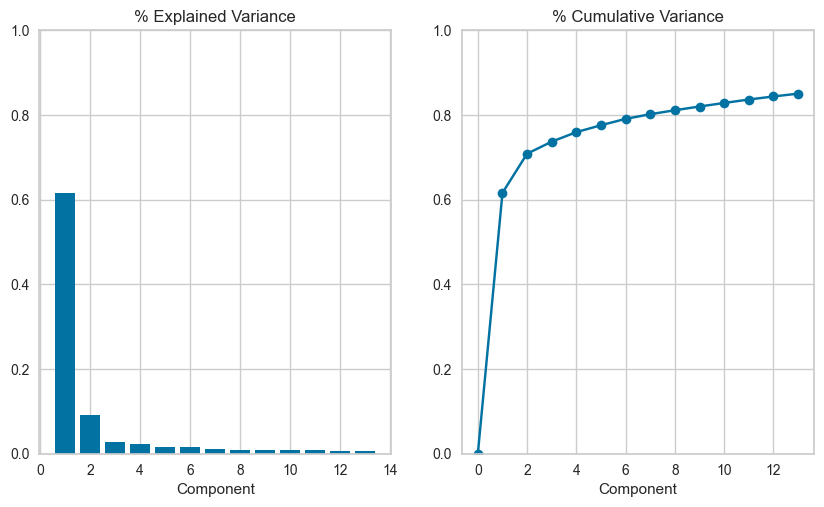

In [104]:
# Global model
pca = PCA(n_components=0.85)
pc = pca.fit_transform(x_train.drop(['Gender', 'Cluster'], axis=1))
pc_train = pd.DataFrame(data = pc, columns = ["PC%02d" %i for i in range(1,pca.n_components_+1)])
pc_test = pca.transform(x_test.drop(['Gender', 'Cluster'], axis=1))

# Create figure
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)
# Explained variance
evr = pca.explained_variance_ratio_
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title=f"% Explained Variance", ylim=(0.0, 1.0)
)
# Cumulative Variance
cv = np.cumsum(evr)
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].set(
    xlabel="Component", title=f"% Cumulative Variance", ylim=(0.0, 1.0)
)
# Set up figure
fig.set(figwidth=10, dpi=100)
fig.show()
    
mi_scores_PC = make_mi_scores(pc_train, y_train)
mi_scores_feat = make_mi_scores(x_train, y_train)
    
keep_features = mi_scores_feat[mi_scores_feat > 0].index.tolist()
keep_PC = mi_scores_PC[mi_scores_PC > 0].index.tolist()

In [126]:
print(mi_scores_feat[mi_scores_feat > 0].cumsum())
print(mi_scores_PC[mi_scores_PC > 0].cumsum())

Left Temporal pole: superior temporal gyrus      0.167092
Left Calcarine fissure and surrounding cortex    0.318444
Right Temporal pole: superior temporal gyrus     0.468690
Left Postcentral gyrus                           0.598976
Left Temporal pole: middle temporal gyrus        0.726732
                                                   ...   
Left Olfactory cortex                            4.288778
Right Anterior orbital gyrus                     4.290899
Left Medial Geniculate                           4.291967
Left Lobule X of cerebellar hemisphere           4.292638
Right Olfactory cortex                           4.292782
Name: MI Scores, Length: 87, dtype: float64
PC05    0.092306
PC02    0.167999
PC07    0.211025
PC10    0.250966
PC12    0.286539
PC03    0.302553
PC04    0.306060
Name: MI Scores, dtype: float64


In [154]:
# Train model
best_model, best_score = train_model(x_train, y_train)

# Compute predictions
predict_train, predict_test = predict(best_model, x_train, x_test)
    
# Compute MAE score
train_score, test_score = compute_mae(y_train, y_test, predict_train, predict_test)
    
#Compute R2 score
train_r2, test_r2 = compute_r2(y_train, y_test, predict_train, predict_test)
    
# Print results
print(f'-- Cluster {i} --')
print(f'n_training_samples = {y_train.shape[0]}')
print(f'n_original_features = {x_train.shape[1]}')
print(f'best_score = {best_score}')
print(f'train_score = {train_score}')
print(f'test_score = {test_score}')
print(f'train_r2_score = {train_r2}')
print(f'test_r2_score = {test_r2}')
print(best_model.get_params())
#print(f'ElasticNet(alpha={best_model.get_params()["alpha"]}, l1_ratio={best_model.get_params()["l1_ratio"]})\n')

Fitting 15 folds for each of 10 candidates, totalling 150 fits
-- Cluster 2 --
n_training_samples = 162
n_original_features = 172
best_score = 0.08688651078493946
train_score = 1.7612726264262015
test_score = 4.11299957419074
train_r2_score = 0.8257153610895609
test_r2_score = 0.09331643742991802
{'memory': None, 'steps': [('clf', AdaBoostRegressor(n_estimators=121, random_state=123))], 'verbose': False, 'clf': AdaBoostRegressor(n_estimators=121, random_state=123), 'clf__base_estimator': None, 'clf__learning_rate': 1.0, 'clf__loss': 'linear', 'clf__n_estimators': 121, 'clf__random_state': 123}


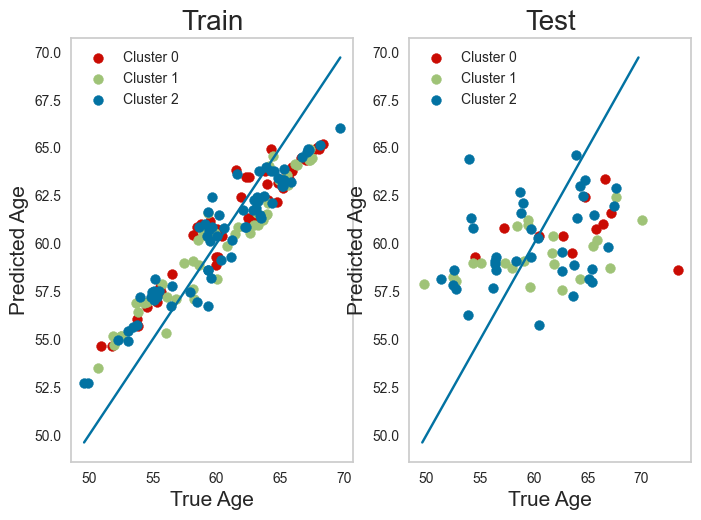

In [155]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_xlabel('True Age', fontsize = 15)
ax1.set_ylabel('Predicted Age', fontsize = 15)
ax1.set_title('Train', fontsize = 20)
ax2.set_xlabel('True Age', fontsize = 15)
ax2.set_ylabel('Predicted Age', fontsize = 15)
ax2.set_title('Test', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    idx_train = x_train['Cluster'] == target
    idx_test = x_test['Cluster'] == target
    ax1.scatter(y_train[idx_train],
                predict_train[idx_train],
               c = color, 
               s = 50)
    ax2.scatter(y_test[idx_test],
                predict_test[idx_test],
               c = color, 
               s = 50)
ax1.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
ax1.grid()
ax2.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
ax2.grid()

p1 = max(max(predict_train), max(np.array(y_train)))
p2 = min(min(predict_train), min(np.array(y_train)))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax2.plot([p1, p2], [p1, p2], 'b-')

# SVR

In [169]:
cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)

# Construct pipeline
pipe_svm = Pipeline([
            ('clf', svm.SVR())
])
# Set grid search params
param_grid_svm = [
  {'clf__C': np.logspace(-3, 5, 10), 'clf__kernel': ['linear']},
  {'clf__C': np.logspace(-3, 5, 10), 'clf__gamma': np.logspace(-10, 0, 20), 'clf__kernel': ['rbf']},
 ]
# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='r2',
            cv=cv, verbose=10,n_jobs=-1, return_train_score = True)
# Fit using grid search
gs_svm.fit(x_train, y_train)
# Best accuracy
print('Best r2: %.3f' % gs_svm.best_score_)
print('Train r2: %.3f' % r2_score(y_train, gs_svm.best_estimator_.predict(x_train)))
print('Test r2: %.3f' % r2_score(y_test, gs_svm.best_estimator_.predict(x_test)))
# Best params
print('\nBest params:\n', gs_svm.best_params_)

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Best r2: 0.122
Train r2: 0.475
Test r2: 0.255

Best params:
 {'clf__C': 12915.496650148827, 'clf__gamma': 1.6237767391887209e-06, 'clf__kernel': 'rbf'}
